# General tests of te AIS

Created on Tue Nov 22 16h24m,  2022

This is a script for the development of general tests

@author: denis


In [ ]:
# Test sky SED
from AIS.Spectral_Energy_Distribution import Sky
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ss = pd.read_csv('AIS/Spectral_Energy_Distribution/moon_magnitude.csv')
wv = np.linspace(350, 1100, 100)
sky = Sky()
sky_sed = sky.calculate_sed('new', wv)
plt.plot(wv, sky_sed, 'b', alpha=0.8)
plt.plot(ss['wavelength'], sky._calculate_photons_density(ss['new']), 'ob')
plt.xlabel('Wavelength (nm)')
plt.ylabel('SED (photons/m2/m)')
plt.show()

In [ ]:
# Test the sparc4 spectral response
from AIS.Spectral_Response import Channel, Atmosphere, Telescope
import matplotlib.pyplot as plt
import numpy as np
import os

sr_total = np.ones(100)
wv = np.linspace(400, 1100, 100)
_channel_id = 1
channel = Channel(_channel_id)
sr = channel.get_spectral_response(wv, 'collimator.csv')
sr_total *= sr
plt.plot(wv, sr, label='collimator')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/dichroic.csv')
sr_total *= sr
plt.plot(wv, sr, label='dichroic')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/camera.csv')
sr_total *= sr
plt.plot(wv, sr, label='focalizer optics')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/ccd.csv')
sr_total *= sr
plt.plot(wv, sr, label='ccd camera')

atm = Atmosphere()
sr = atm.get_spectral_response(wv, 1, 'photometric')
sr_total *= sr
plt.plot(wv, sr, label='atmosphere')

tel = Telescope()
sr = tel.get_spectral_response(wv)
sr_total *= sr
plt.plot(wv, sr, label='telescope')


plt.plot(wv, sr_total, 'k', label='total')
plt.legend()
plt.ylim(0, 1.1)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmitance (%)')
plt.title(f'Channel {_channel_id}')
plt.savefig(os.path.join('notebook','figures', f'Channel {_channel_id}.png'))
plt.show()


In [ ]:
# Test the sparc4 spectral response
from AIS.Spectral_Response import Channel, Atmosphere
import matplotlib.pyplot as plt
import numpy as np
import os

sr_total = np.ones(100)
wv = np.linspace(400, 1100, 100)
_channel_id = 2
channel = Channel(_channel_id)
sr = channel.get_spectral_response(wv, 'collimator.csv')
sr_total *= sr
plt.plot(wv, sr, label='collimator')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/dichroic.csv')
sr_total *= sr
plt.plot(wv, sr, label='dichroic')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/camera.csv')
sr_total *= sr
plt.plot(wv, sr, label='focalizer optics')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/ccd.csv')
sr_total *= sr
plt.plot(wv, sr, label='ccd camera')

atm = Atmosphere()
sr = atm.get_spectral_response(wv, 1, 'photometric')
sr_total *= sr
plt.plot(wv, sr, label='atmosphere')

tel = Telescope()
sr = tel.get_spectral_response(wv)
sr_total *= sr
plt.plot(wv, sr, label='telescope')

plt.plot(wv, sr_total, 'k', label='total')
plt.legend()
plt.ylim(0, 1.1)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmitance (%)')
plt.title(f'Channel {_channel_id}')
plt.savefig(os.path.join('notebook','figures', f'Channel {_channel_id}.png'))
plt.show()


In [ ]:
# Test the sparc4 spectral response
from AIS.Spectral_Response import Channel, Atmosphere, Telescope
import matplotlib.pyplot as plt
import numpy as np
import os

sr_total = np.ones(100)
wv = np.linspace(400, 1100, 100)
_channel_id = 3
channel = Channel(_channel_id)
sr = channel.get_spectral_response(wv, 'collimator.csv')
sr_total *= sr
plt.plot(wv, sr, label='collimator')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/dichroic.csv')
sr_total *= sr
plt.plot(wv, sr, label='dichroic')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/camera.csv')
sr_total *= sr
plt.plot(wv, sr, label='focalizer optics')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/ccd.csv')
sr_total *= sr
plt.plot(wv, sr, label='ccd camera')

atm = Atmosphere()
sr = atm.get_spectral_response(wv, 1, 'photometric')
sr_total *= sr
plt.plot(wv, sr, label='atmosphere')

tel = Telescope()
sr = tel.get_spectral_response(wv)
sr_total *= sr
plt.plot(wv, sr, label='telescope')

plt.plot(wv, sr_total, 'k', label='total')
plt.legend()
plt.ylim(0, 1.1)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmitance (%)')
plt.title(f'Channel {_channel_id}')
plt.savefig(os.path.join('notebook','figures', f'Channel {_channel_id}.png'))
plt.show()


NameError: name 'Telescope' is not defined

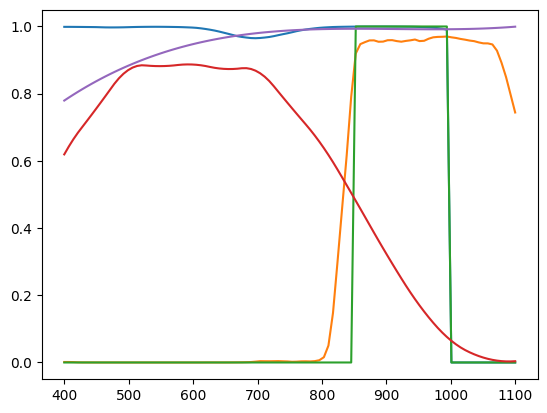

In [1]:
# Test the sparc4 spectral response
from AIS.Spectral_Response import Channel, Atmosphere
import matplotlib.pyplot as plt
import numpy as np
import os

sr_total = np.ones(100)
wv = np.linspace(400, 1100, 100)
_channel_id = 4
channel = Channel(_channel_id)
sr = channel.get_spectral_response(wv, 'collimator.csv')
sr_total *= sr
plt.plot(wv, sr, label='collimator')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/dichroic.csv')
sr_total *= sr
plt.plot(wv, sr, label='dichroic')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/camera.csv')
sr_total *= sr
plt.plot(wv, sr, label='focalizer optics')
sr = channel.get_spectral_response(wv, f'Channel {_channel_id}/ccd.csv')
sr_total *= sr
plt.plot(wv, sr, label='ccd camera')

atm = Atmosphere()
sr = atm.get_spectral_response(wv, 1, 'photometric')
sr_total *= sr
plt.plot(wv, sr, label='atmosphere')

tel = Telescope()
sr = tel.get_spectral_response(wv)
sr_total *= sr
plt.plot(wv, sr, label='telescope')

plt.plot(wv, sr_total, 'k', label='total')
plt.legend()
#plt.ylim(0, 1.1)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmitance (%)')
plt.title(f'Channel {_channel_id}')
plt.savefig(os.path.join('notebook','figures', f'Channel {_channel_id}.png'))
plt.show()


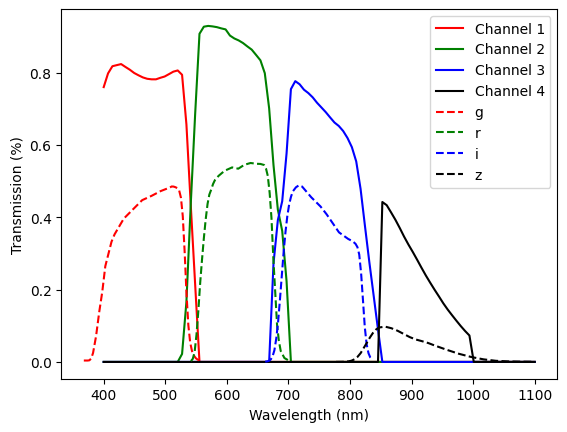

In [4]:

# Test the sparc4 spectral response + atmosphere + telescope
from AIS.Spectral_Response import Channel, Atmosphere, Telescope
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

sed = np.ones(100)
wv = np.linspace(400, 1100, 100)
atm = Atmosphere()
sr = atm.get_spectral_response(wv, 1, 'photometric')
tel = Telescope()
sr *= tel.get_spectral_response(wv)
colors = ['r', 'g', 'b', 'k']
for i in [1, 2, 3, 4]:
    channel = Channel(i)
    channel.write_sparc4_operation_mode('photometry')
    ch1_spectral_response = channel.apply_spectral_response(sed, wv) #*sr
    plt.plot(wv, ch1_spectral_response, colors[i-1], label=f'Channel {i}')

data = pd.read_csv('notebook/data_files/g_filter.csv')
plt.plot(data['Wavelength (angstroms)']/10, data['Transmission'], 'r--', label='g')
data = pd.read_csv('notebook/data_files/r_filter.csv')
plt.plot(data['Wavelength (angstroms)']/10, data['Transmission'], 'g--', label='r')
data = pd.read_csv('notebook/data_files/i_filter.csv')
plt.plot(data['Wavelength (angstroms)']/10, data['Transmission'], 'b--', label='i')
data = pd.read_csv('notebook/data_files/z_filter.csv')
plt.plot(data['Wavelength (angstroms)']/10, data['Transmission'], 'k--', label='z')


plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmission (%)')
plt.savefig(os.path.join('notebook', 'figures', 'sparc4_photometry.png'), dpi=300)
plt.show()


In [ ]:
# Test the blackbody profile
from AIS. Artificial_Image_Simulator import Artificial_Image_Simulator
from AIS.Spectral_Energy_Distribution import Source
import matplotlib.pyplot as plt
ccd_operation_mode = {
    'em_mode': 'Conv',
    'em_gain': 1,
    'preamp': 1,
    'readout': 1,
    'binn': 1,
    't_exp': 1,
    'image_size': 100
}

ais = Artificial_Image_Simulator(ccd_operation_mode, 1, -70)

ais.create_source_sed('blackbody', 15, (400, 1100, 100), 5700)
ais.create_sky_sed('new')
plt.plot(ais.wavelength, ais.source_sed, label='Blackbody')
ais.apply_atmosphere_spectral_response()
plt.plot(ais.wavelength, ais.source_sed, label='Blackbody with atmosphere')
ais.apply_telescope_spectral_response()
plt.plot(ais.wavelength, ais.source_sed,
         label='Blackbody with atmosphere and telescope')
ais.apply_sparc4_spectral_response('photometry')
plt.plot(ais.wavelength, ais.source_sed,
         label='Blackbody with atmosphere, telescope and SPARC4')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('SED (photons/m2/nm)')
plt.title('Blackbody SED')
plt.show()

In [ ]:
# Test the _read_spectral_library function
from AIS. Artificial_Image_Simulator import Artificial_Image_Simulator
import matplotlib.pyplot as plt
ccd_operation_mode = {
    'em_mode': 'Conv',
    'em_gain': 1,
    'preamp': 1,
    'readout': 1,
    'binn': 1,
    't_exp': 1,
    'image_size': 100
}

ais = Artificial_Image_Simulator(ccd_operation_mode, 1, -70)

ais.create_source_sed('spectral_library', 15, (400, 1100, 100), spectral_type='g5v')
ais.create_sky_sed('new')
plt.plot(ais.wavelength, ais.source_sed, label='G5 v')
ais.apply_atmosphere_spectral_response()
plt.plot(ais.wavelength, ais.source_sed, label='G5 v + atmosfera')
ais.apply_telescope_spectral_response()
plt.plot(ais.wavelength, ais.source_sed,
         label='G5 v + atmosfera + telescópio')
ais.apply_sparc4_spectral_response('photometry')
plt.plot(ais.wavelength, ais.source_sed,
         label='G5 v + atmosfera + telescópio + instrumento')
plt.legend()
plt.xlabel('Comprimento de onda (nm)')
plt.ylabel(r'DEE (fótons/m$^2$/nm)')
plt.xlim(400, 1100)
plt.ylim(0, 1e11)
plt.savefig('notebook/figures/spectral_library.png', dpi=300)
plt.show()

In [ ]:
# Test the sbpy package
from sbpy.calib import Vega, vega_fluxd
print(vega_fluxd.get()["Johnson V"])


In [ ]:

# Test the atmosphere spectral response
from AIS.Spectral_Response import Atmosphere
import matplotlib.pyplot as plt
import numpy as np

obj_wavelength = np.linspace(400, 1100, 100)
atmosphere = Atmosphere()
spectral_response = atmosphere.get_spectral_response(obj_wavelength, 1)
plt.plot(obj_wavelength, spectral_response)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmitance (%)')
plt.show()


In [ ]:
# Test telescope spectral response
from AIS.Spectral_Response import Telescope
import matplotlib.pyplot as plt
import numpy as np

obj_wavelength = np.linspace(400, 1100, 100)
telescope = Telescope()
spectral_response = telescope.get_spectral_response(obj_wavelength)
plt.plot(obj_wavelength, spectral_response, 'b')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmitance')
plt.savefig('notebook' + '\\figures\\telescope_spectral_response.png')
plt.show()


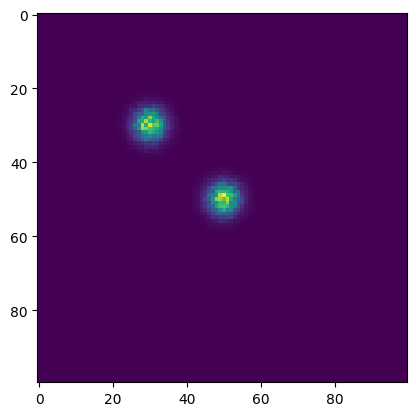

In [1]:
# Test the PSF class
from AIS.Point_Spread_Function import Point_Spread_Function
import matplotlib.pyplot as plt
ccd_operation_mode = {
    'em_mode': 'Conv',
    'em_gain': 1,
    'preamp': 1,
    'readout': 1,
    'binn': 1,
    't_exp': 1,
    'image_size': 100
}
psf = Point_Spread_Function(ccd_operation_mode, 1)
image = psf.create_star_image((50, 50), 1e3, 1e3)
plt.imshow(image)
plt.show()

In [ ]:
# Test the AIS.create_image function
from AIS.Artificial_Image_Simulator import Artificial_Image_Simulator
import os

ccd_operation_mode = {
    'em_mode': 'Conv',
    'em_gain': 1,
    'preamp': 1,
    'readout': 1,
    'binn': 1,
    't_exp': 1,
    'image_size': 100
}

wavelength_interval = (400, 1100, 100)
ais = Artificial_Image_Simulator(ccd_operation_mode, 1, -70)
ais.create_source_sed('blackbody', 15, wavelength_interval, 5700)
ais.create_sky_sed('new')
ais.apply_atmosphere_spectral_response(air_mass=1.2, sky_condition='photometric')
ais.apply_telescope_spectral_response()
ais.apply_sparc4_spectral_response('photometry')
ais.create_artificial_image(os.path.join('E:', 'images', 'test'))

In [ ]:
# Calc the ajust of the spectral response of the telescope

import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import splrep, splev
from scipy.optimize import curve_fit
from sys import exit
import os

wv = [440, 530, 650]
M1 = [86.392, 85.641, 83.825]
M2 = [92.40375, 91.3025, 89.65375]

ss = pd.read_csv('AIS/Spectral_Response/telescope.csv')


def func(x, c):
    ss = pd.read_csv('AIS/Spectral_Response/telescope.csv')
    spl = splrep(ss['Wavelength (nm)'], ss['Transmitance (%)'])
    spectral_response = splev(x, spl)
    return spectral_response*c


popt_M1, _ = curve_fit(func, wv, M1)
popt_M2, _ = curve_fit(func, wv, M2)

plt.plot(wv, M1, 'o-r', label='M1')
plt.plot(wv, M2, 'o-b', label='M2')
plt.plot(ss['Wavelength (nm)'], ss['Transmitance (%)']
         * popt_M1[0], 'g', label=f'teórioco * {popt_M1[0]:.3f}')
plt.plot(ss['Wavelength (nm)'], ss['Transmitance (%)']
         * popt_M2[0], 'k', label=f'teórioco * {popt_M2[0]:.3f}')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (%)')
plt.savefig(os.path.join('notebook', 'figures', 'adjust_aluminium_curve.png'))
plt.show()

In [ ]:
# Create a time series of images

from AIS.Artificial_Image_Simulator import Artificial_Image_Simulator
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from sys import exit
from time import sleep
import os

ccd_operation_mode = {
    'em_mode': 'Conv',
    'em_gain': 1,
    'preamp': 1,
    'readout': 1,
    'binn': 1,
    't_exp': 1,
    'image_size': 100
}

n = 100
images_path = os.path.join('E:', 'images', 'test')
time = np.linspace(0, 2 * pi, n)
mags = 15 + 0.1 * np.sin(time) + np.random.normal(0, 0.01, n)

ais = Artificial_Image_Simulator(
    ccd_operation_mode, channel_id=1, ccd_temperature=-70)
ais.create_bias_image(images_path, 10)
ais.create_flat_image(images_path, 20)

for mag in mags:
    ais = Artificial_Image_Simulator(
        ccd_operation_mode, channel_id=1, ccd_temperature=-70)
    ais.create_source_sed(calculation_method='blackbody',
                          magnitude=mag, wavelength_interval=(400, 1100, 1000), temperature=5700)
    ais.create_sky_sed(moon_phase='new')
    ais.apply_atmosphere_spectral_response()
    ais.apply_telescope_spectral_response()
    ais.apply_sparc4_spectral_response(acquisition_mode='photometry')
    ais.create_artificial_image(
        image_path=images_path, star_coordinates=(50, 50))
    sleep(ccd_operation_mode['t_exp'])


In [ ]:
#Polarimetric spectral response curves

from AIS.Spectral_Response import Channel
import numpy as np
import matplotlib.pyplot as plt
import os

wv = np.linspace(300, 1200, 100)
channel = Channel(1)
spectral_response = channel.get_spectral_response(wv, 'polarizer.csv')
plt.plot(wv, spectral_response, 'b', label='Polarizer')

spectral_response = channel.get_spectral_response(wv, 'depolarizer.csv')
plt.plot(wv, spectral_response, 'r', label='Depolarizer')

spectral_response = channel.get_spectral_response(wv, 'retarder.csv')
plt.plot(wv, spectral_response, 'g', label='Retarder')

spectral_response = channel.get_spectral_response(wv, 'analyser.csv')
plt.plot(wv, spectral_response, 'k', label='Analyser')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmitance (%)')
plt.legend()
plt.savefig(os.path.join('notebook','figures', 'polarimetric_spectral_response.png'), dpi=300)
plt.show()

In [ ]:
#Test the polarimetric mode

from AIS.Spectral_Response import Channel
import numpy as np
import matplotlib.pyplot as plt
from sys import exit

n = 100
wv = np.linspace(300, 1000, n)
sed = np.ones(n)
ch = Channel(1)
ch.write_sparc4_operation_mode(acquisition_mode='polarimetry', calibration_wheel='polarizer',
                               retarder_waveplate='half', retarder_waveplate_angle=22.5)

sed = ch.apply_spectral_response(sed, wv)
plt.plot(wv, sed[0], 'b')
plt.plot(wv, sed[1], 'k')
plt.show()

In [ ]:
#Create video polarimetry

from AIS.Artificial_Image_Simulator import Artificial_Image_Simulator
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

ccd_operation_mode = {
    'em_mode': 'Conv',
    'em_gain': 1,
    'preamp': 1,
    'readout': 1,
    'binn': 1,
    't_exp': 1,
    'image_size': 100
}
path = r'E:\images\test'

ais = Artificial_Image_Simulator(
    ccd_operation_mode, channel_id=1, ccd_temperature=-70)

for i in range(286, 360):
    print(i)
    ais.create_source_sed(calculation_method='blackbody',
                          magnitude=12, wavelength_interval=(400, 1100, 1000), temperature=5700)
    ais.create_sky_sed(moon_phase='new')
    ais.apply_atmosphere_spectral_response()
    ais.apply_telescope_spectral_response()
    ais.apply_sparc4_spectral_response(
        'polarimetry', 'polarizer', 'half', i)
    image = ais.create_artificial_image(
        image_path=path, star_coordinates=(50, 50))
    median = np.median(image)
    std = np.std(image)
    file = os.path.join(path, f'ret_angle_{i:03}.png')
    ann = plt.annotate(f'waveplate angle: {i} deg', (0.9, 0.9),
                       xycoords='axes fraction', ha='right', color='white')
    plt.imshow(image[0], cmap='gray',
               origin='lower', vmin=median-3*std, vmax=2*median)
    plt.savefig(file)
    ann.remove()

#---------------------------------------------------------------------------------------------------

# Create GIF
import os
import cv2
import glob
import imageio
from sys import exit
import matplotlib.pyplot as plt
path = r'E:\images\test'
files = os.listdir(path)
frameSize = (640, 480)

out = cv2.VideoWriter(path + '\\' + 'output_video.mp4',
                      cv2.VideoWriter_fourcc(*'mp4v'), 15, frameSize)


for filename in glob.glob(path + '\\*.png'):
    img = cv2.imread(filename)    
    out.write(img)

out.release()

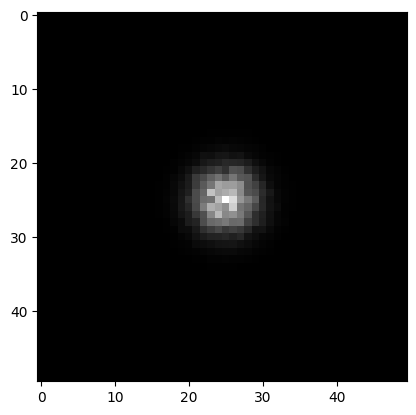

In [7]:
#Create gaussian with noise
from AIS.Point_Spread_Function import Point_Spread_Function
import matplotlib.pyplot as plt
import os
ccd_operation_mode = {
    'em_mode': 'Conv',
    'em_gain': 1,
    'preamp': 1,
    'readout': 1,
    'binn': 1,
    't_exp': 1,
    'image_size': 50
}
psf = Point_Spread_Function(ccd_operation_mode, 1)
image = psf.create_star_image((25, 25), 1e3)
plt.imshow(image, cmap='gray')
plt.savefig(os.path.join('notebook', 'figures', 'gaussiana_com_ruido.png'), dpi=300)